In [13]:
from ukbcohort import utils
import pandas as pd
import numpy as np

import plotly.express as px

In [185]:
def filterByEids(pathToMain: str, eids: list) -> pd.DataFrame():
    '''Filter main dataset to only include eids.
    
    Keyword arguments:
    ------------------
    pathToMain: str
        location of main dataframe
    eids: list(str)
        list of patient eids

    Returns:
    --------
    filteredDf: pd.DataFrame
        main dataset filtered to only include specific eids
        
    '''
    mainDf = pd.read_csv(pathToMain, dtype='string')
    filteredDf = mainDf.query('eid in {}'.format(eids))

    return filteredDf

def translateDataframe(df: pd.DataFrame, pathToShowcase: str, pathToCoding: str, fields: list = ['34-0.0', '52-0.0', '22001-0.0', '21000-0.0',  '22021-0.0']):
# get relevant columns
    filtDf = df.filter(items=fields)
    
# create dictionary that contains all codes
    fieldDict = dict()
    showcase = pd.read_csv(pathToShowcase, dtype='string')
    coding = pd.read_csv(pathToCoding, dtype='string')
    codes = []


    for field in fields:
        field = field.split('-')[0]
        fieldDict[field] = dict()
        try:
            fieldDict[field]['name'] = showcase.query('FieldID == "{}"'.format(field))['Field'].values[0]
        except:
            fieldDict[field]['name'] = field
        try: 
            fieldDict[field]['coding'] = int(showcase.query('FieldID == "{}"'.format(field))['Coding'].values[0])
            codes.append(int(showcase.query('FieldID == "{}"'.format(field))['Coding'].values[0]))
        except:
            fieldDict[field]['coding'] = np.nan
        try: 
            fieldDict[field]['type'] = showcase.query('FieldID == "{}"'.format(field))['ValueType'].values[0]
        except:
            fieldDict[field]['type'] = np.nan
            
# create coding dictionary for values
    codingDict = dict()
    for c in set(codes):
        relevantDf = coding.query('Coding == "{}"'.format(c))
        codingDict['{}'.format(c)] = dict(zip(relevantDf.Value.astype(str), relevantDf.Meaning.astype(str)))

# create dictionary to rename columns
    renameDict = dict()
    for col in filtDf.columns:
        try:
            renameDict[col] = col.split('-')[0]
        except:
            renameDict[col] = col
        
# rename columns
    filtDf = filtDf.rename(columns=renameDict)
    filtDf =filtDf.astype(str)
    print(filtDf)

# replace values
    for c in filtDf.columns:
        c = c.split('-')[0]
        codingScheme = fieldDict[c]['coding']

        if not pd.isna(codingScheme):
            if str(codingScheme) in codingDict.keys():
                print(codingDict[f'{codingScheme}'])
                print(filtDf[c].map(codingDict[f'{codingScheme}']))
                filtDf[c] = filtDf[c].map(codingDict[f'{codingScheme}'])
        
    nameDict = dict()
    for col in filtDf.columns:
        try:
            nameDict[col] = showcase.query('FieldID == "{}"'.format(col))['Field'].values[0]
        except:
            nameDict[col] = col
    
# understand column types to extract meaningful statistics
    for col in filtDf.columns: 
        colType = fieldDict[col]['type']
        if colType == 'Integer' or colType == "Continuous":
            filtDf[col] = pd.to_numeric(filtDf[col], errors='coerce')
        elif colType == 'Date': 
            filtDf[col] = pd.to_datetime(filtDf[col], errors='coerce')

# rename columns to make them more readable
    filtDf = filtDf.rename(columns=nameDict)
    
    return filtDf

def displayHistograms(df: pd.DataFrame):
    for c in df.columns: 
        display(px.histogram(df, x=c))
        
# def getStats(df: pd.Series): 
    


In [321]:
def compute_stats(main_filename: str, eids: list, showcase_filename: str, coding_filename: str,
                  column_keys: list = ['34-0.0', '52-0.0', '22001-0.0', '21000-0.0', '22021-0.0']) -> (dict, pd.DataFrame):
    """Returns basic statistics for given columns and a translated dataframe.

    Keyword arguments:
    ------------------
    main_filename: str
        path and filename of main dataset
    eids: list[str]
        list of eids
    showcase_filename: str
        path and filename of showcase file
    coding_filename: str
        path and filename of coding file
    column_keys: list[str]
        list of column keys to include from the main dataset

    Returns:
    --------
    (stats_dict, translated_df): (dict, pd.DataFrame)
        stats_dict is a dictionary with one entry per column and the fields: type, status, stats_table, 
        `stats_table`: pd.Series with statistics 
        `status`: str, with success or error message
        `type`: description of the table type
        translated_df is the extraction of the relevant columns and decoded values
    """

    # get relevant columns
    main_df = utils.quick_filter_df(main_filename=main_filename, eids=eids)
    main_df = main_df.filter(items=column_keys)

    # create dictionary that contains all codes
    field_dict = dict()
    showcase = pd.read_csv(showcase_filename, dtype='string')
    coding = pd.read_csv(coding_filename, dtype='string')
    codes = []

    for field in column_keys:
        field = field.split('-')[0]
        field_dict[field] = dict()
        try:
            field_dict[field]['name'] = showcase.query('FieldID == "{}"'.format(field))['Field'].values[0]
        except:
            field_dict[field]['name'] = field
        try:
            field_dict[field]['coding'] = int(showcase.query('FieldID == "{}"'.format(field))['Coding'].values[0])
            codes.append(int(showcase.query('FieldID == "{}"'.format(field))['Coding'].values[0]))
        except:
            field_dict[field]['coding'] = np.nan
        try:
            field_dict[field]['type'] = showcase.query('FieldID == "{}"'.format(field))['ValueType'].values[0]
        except:
            field_dict[field]['type'] = np.nan

    # create coding dictionary for values
    coding_dict = dict()
    for col in set(codes):
        relevant_df = coding.query('Coding == "{}"'.format(col))
        coding_dict['{}'.format(col)] = dict(zip(relevant_df.Value, relevant_df.Meaning))

    # create dictionary to rename columns
    rename_dict = dict()
    for col in main_df.columns:
        rename_dict[col] = col.split('-')[0]

    # rename columns
    main_df = main_df.rename(columns=rename_dict)

    # replace values
    for col in main_df.columns:
        col_type = field_dict[col]['type']
        coding_scheme = field_dict[col]['coding']

        print(f'{col}, {col_type}, {coding_scheme}')
        if col_type == 'Integer' or col_type == 'Categorical single':
            main_df[col] = main_df[col].astype(pd.Int32Dtype()).astype(str)
        if not pd.isna(coding_scheme):
            if str(coding_scheme) in coding_dict.keys():
                main_df[col] = main_df[col].map(coding_dict[f"{coding_scheme}"])

    name_dict = dict()
    statistics_dict = dict()
    
    for col in main_df.columns:
        try:
            name_dict[col] = field_dict[col]['name']
            statistics_dict[field_dict[col]['name']] = {}
        except:
            name_dict[col] = col
            statistics_dict[col] = {}

    # understand column types to extract meaningful statistics
    for col in main_df.columns:
        col_type = field_dict[col]['type']
        if col_type in ['Integer', 'Continuous']:
            main_df[col] = pd.to_numeric(main_df[col], errors='coerce')
            statistics_dict[field_dict[col]['name']]['type'] = 'Pandas describe'
            statistics_dict[field_dict[col]['name']]['status'] = 'success'
            statistics_dict[field_dict[col]['name']]['stats_table'] = main_df[col].describe()
        elif col_type in ['Date', 'Time']:
            main_df[col] = pd.to_datetime(main_df[col], errors='coerce')
            statistics_dict[field_dict[col]['name']]['type'] = 'Pandas describe'
            statistics_dict[field_dict[col]['name']]['status'] = 'success'
            statistics_dict[field_dict[col]['name']]['stats_table'] = main_df[col].describe()
        elif col_type in ['Categorical multiple', 'Text', 'Compound']: 
            statistics_dict[field_dict[col]['name']]['type'] = 'NA'
            statistics_dict[field_dict[col]['name']]['status'] = f'ERROR: stats on {col_type} data currently not supported'
            statistics_dict[field_dict[col]['name']]['stats_table'] = pd.DataFrame()
        else:
            statistics_dict[field_dict[col]['name']]['type'] = 'Value count'
            statistics_dict[field_dict[col]['name']]['status'] = 'success'
            statistics_dict[field_dict[col]['name']]['stats_table'] = main_df[col].value_counts(normalize=False)
            

    # rename columns to make them more readable
    main_df = main_df.rename(columns=name_dict)
    
    return statistics_dict, main_df


In [322]:
stats, newDf = compute_stats(main_filename, eids, pathToShowcase, pathToCoding, ['34-0.0', '52-0.0', '22001-0.0', '21000-0.0',  '22021-0.0'])
stats

34, Integer, nan
52, Categorical single, 8
22001, Categorical single, 9
21000, Categorical single, 1001
22021, Categorical single, 682


{'Year of birth': {'type': 'Pandas describe',
  'status': 'success',
  'stats_table': count      20.000000
  mean     1953.000000
  std         9.020445
  min      1938.000000
  25%      1945.750000
  50%      1951.500000
  75%      1962.500000
  max      1968.000000
  Name: 34, dtype: float64},
 'Month of birth': {'type': 'Value count',
  'status': 'success',
  'stats_table': June         3
  March        3
  July         3
  September    2
  October      2
  February     2
  January      2
  May          1
  August       1
  December     1
  Name: 52, dtype: int64},
 'Genetic sex': {'type': 'Value count',
  'status': 'success',
  'stats_table': Male      10
  Female     9
  Name: 22001, dtype: int64},
 'Ethnic background': {'type': 'Value count',
  'status': 'success',
  'stats_table': British                       17
  Irish                          1
  Any other white background     1
  Any other Asian background     1
  Name: 21000, dtype: int64},
 'Genetic kinship to other partic

In [319]:
stats['Month of birth']['type']

'normalized value count'

In [225]:
eids = ['1000015',
 '1000027',
 '1000039',
 '1000040',
 '1000053',
 '1000064',
 '1000071',
 '1000088',
 '1000096',
 '1000109',
 '1000117',
 '1000125',
 '1000132',
 '1000148',
 '1000154',
 '1000163',
 '1000176',
 '1000180',
 '1000191',
 '1000204']

main_filename = '../../toy-data/ukb41268_head100.csv'
df = utils.quick_filter_df(main_filename, eids)
pathToShowcase = '../dataFiles/showcase.csv'
pathToCoding = '../dataFiles/codings.csv'

In [184]:
newDf

,Year of birth,Month of birth,Genetic sex,Ethnic background,Genetic kinship to other participants
0,1964,October,NaN,British,NaN
1,1947,July,NaN,British,NaN
2,1964,October,NaN,British,NaN
3,1957,February,NaN,British,NaN
4,1938,June,NaN,British,NaN
5,1968,August,NaN,British,NaN
6,1955,May,NaN,British,NaN
7,1950,July,NaN,British,NaN
8,1945,December,NaN,British,NaN
9,1945,January,NaN,British,NaN


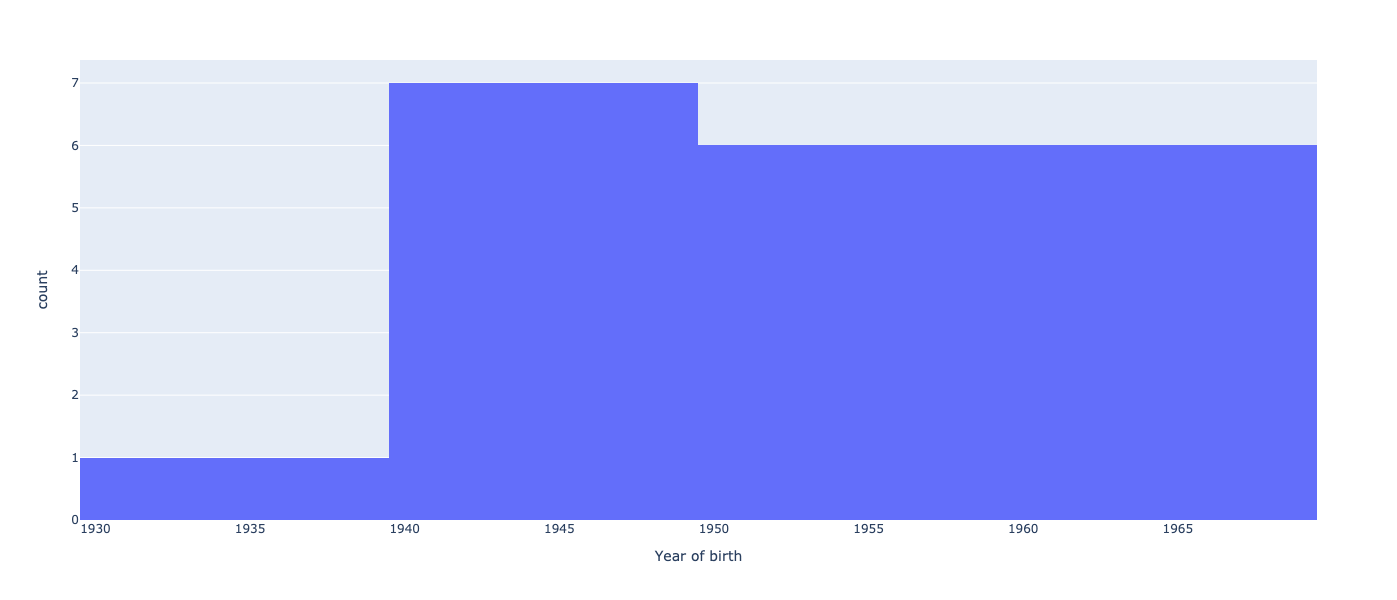

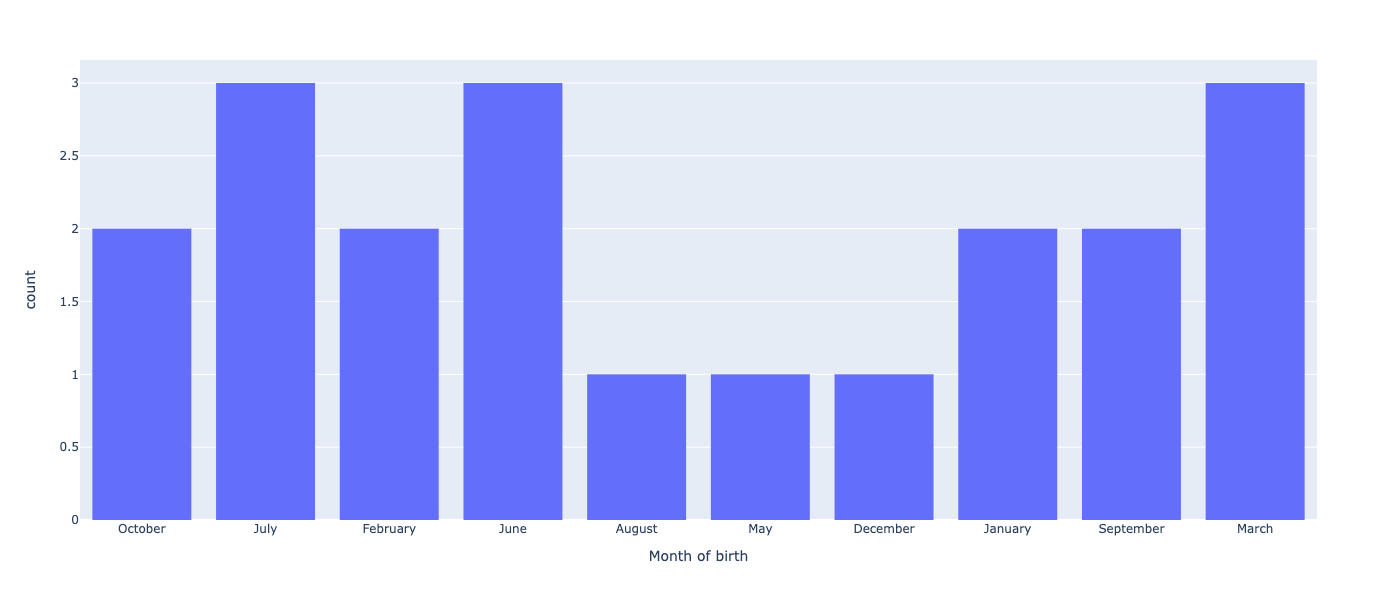

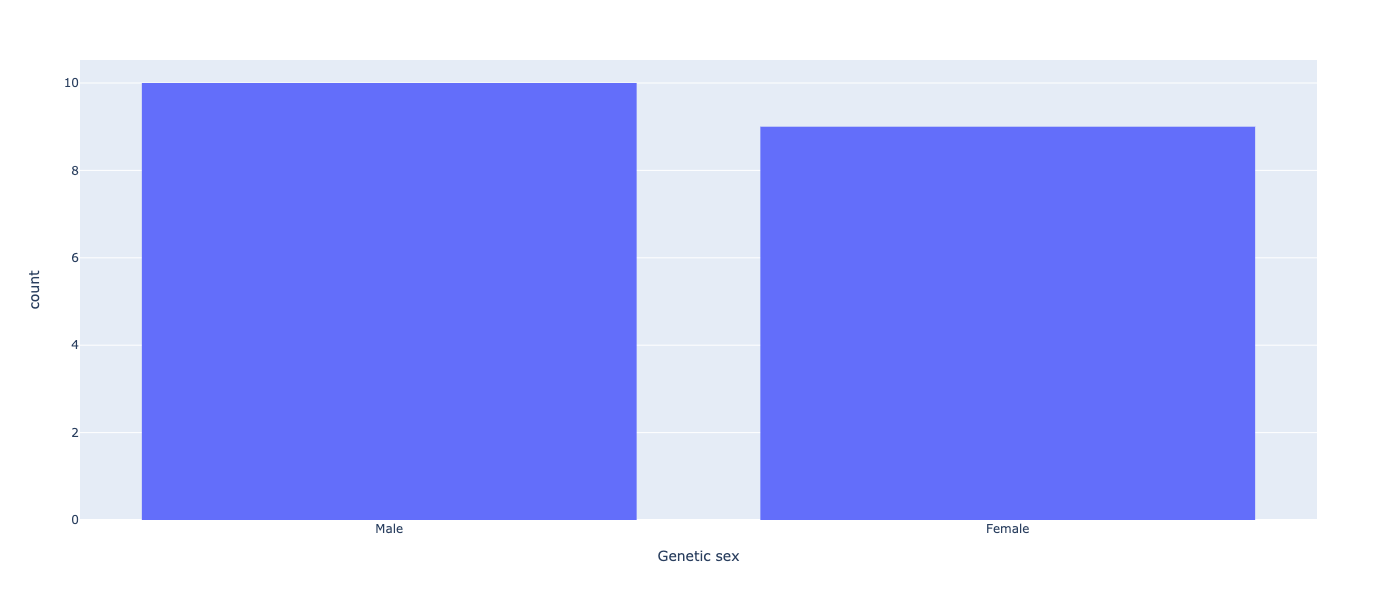

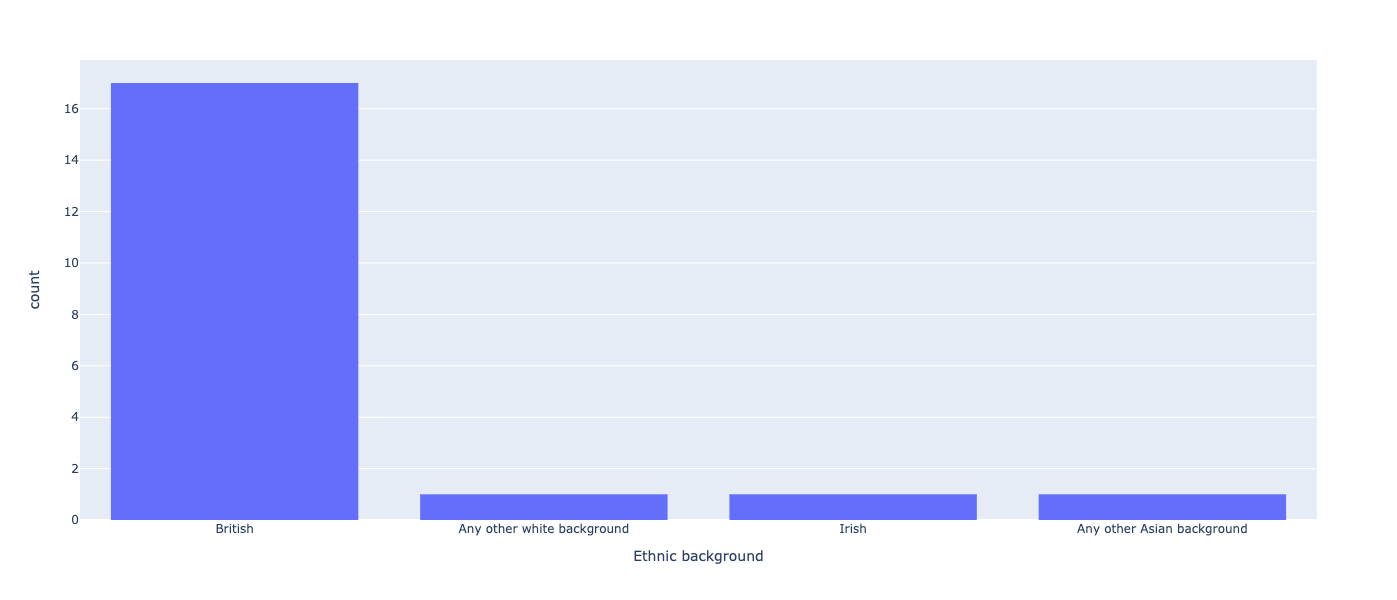

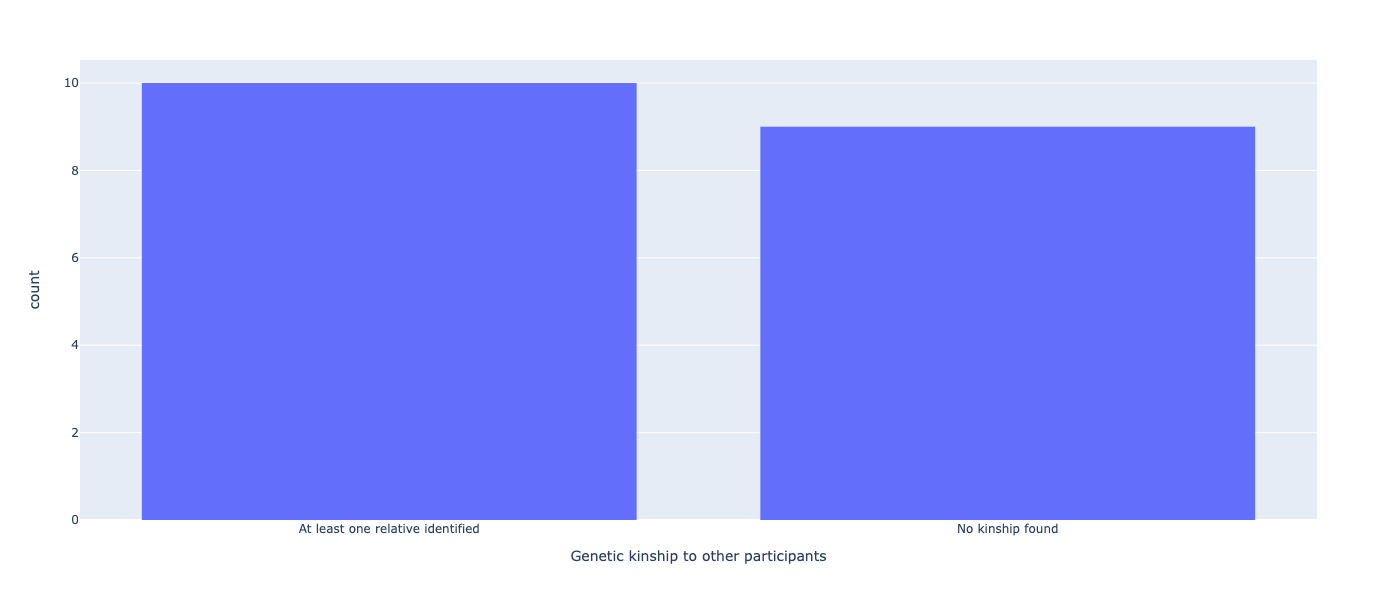

In [267]:
displayHistograms(newDf)

In [745]:
%%timeit
lookforEids = ['1000510', '1000522', '1000536', '1000545', '1000558', '1000561', '1000574',
 '1000583']

colnames=pd.read_csv(pathToMain, nrows=0).columns
dfEids = pd.read_csv(pathToMain, usecols=['eid'])

wanted = list(dfEids[dfEids['eid'].isin(lookforEids)].index)
wanted = [x+1 for x in wanted]

5.08 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [746]:
%%timeit
dfOut = pd.read_csv(pathToMain, skiprows=lambda x: x not in wanted, names=colnames)

869 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [743]:
%%timeit
df = pd.read_csv(pathToMain)
dfOut = df[df['eid'].isin(lookforEids)]

/usr/local/lib/python3.7/site-packages/IPython/core/magic.py:187: DtypeWarning:

Columns (53,54,55,1360,1361,1362,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3067,3068,3069,3070,3071,3072,3073,3074,3075,3076,3324,3325,3326,3336,3337,3338,3360,3361,3362,3698,3699,3700,3701,3711,3712,3713,3714,3730,3731,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3944,3945,3961,3962,3963,4311,4324,4325,4326,4329,4330,4331,4335,4336,4337,4341,4342,4343,4348,4359,4360,4361,4371,4

1.87 s ± 43.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [739]:
dfOut

,eid,3-0.0,3-1.0,3-2.0,3-3.0,21-0.0,21-1.0,21-2.0,21-3.0,31-0.0,...,132152-0.0,132153-0.0,132154-0.0,132155-0.0,132156-0.0,132157-0.0,132158-0.0,132159-0.0,132160-0.0,132161-0.0
50,1000510,412,NaN,NaN,NaN,1,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,1000522,700,NaN,NaN,NaN,1,NaN,NaN,NaN,0,...,1998-05-21,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,1000536,521,NaN,NaN,NaN,1,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,1000545,574,NaN,NaN,NaN,1,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,1000558,427,NaN,NaN,NaN,1,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,1000561,311,NaN,NaN,NaN,1,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,1000574,445,NaN,620.0,NaN,1,NaN,1.0,NaN,0,...,2005-04-18,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,1000583,254,NaN,NaN,NaN,1,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
config = exec(open(f'../config.py').read())

In [125]:
main_filename

'~/IBM/GEN'